In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cudf as cu

import tensorflow as tf
from tensorflow import keras

2023-05-10 21:15:04.171629: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 21:15:04.335845: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 21:15:04.919975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
np.set_printoptions(precision=3, suppress=True)

In [25]:
df: cu.DataFrame = cu.read_csv("../out.csv", nrows=2000)
df["tiempo_min"] = cu.to_datetime(df["tiempo_min"]).astype(int) / 10**9
df["tiempo_max"] = cu.to_datetime(df["tiempo_max"]).astype(int) / 10**9
df["duracion"] = df["tiempo_max"] - df["tiempo_min"]
df.drop(inplace=True, columns=["uuid", "speedKMH", "tiempo_max", "pubMillis", "updateMillis"])
# df = cu.get_dummies(df, columns=["endNode", "city"])
# end_nodes = cu.DataFrame(df["endNode"].drop_duplicates())
# end_nodes.reset_index(inplace=True, drop=True)
# end_nodes.reset_index(inplace=True)
# end_nodes.columns = ["endNodeNum", "endNode"]
# df = df.merge(end_nodes, on="endNode")
# ciudades = cu.DataFrame(df["city"].drop_duplicates())
# ciudades.reset_index(inplace=True, drop=True)
# ciudades.reset_index(inplace=True)
# ciudades.columns = ["cityNum", "city"]
# ciudades
# df = df.merge(ciudades, on="city")
df.drop(inplace=True, columns=["city", "endNode"])
datos_entrenamiento: pd.DataFrame = df.sample(frac=0.8, random_state=0).to_pandas()
datos_prueba = df.drop(datos_entrenamiento.index)

features_entrenamiento = datos_entrenamiento.copy()
features_prueba = datos_prueba.copy()

etiquetas_entrenamiento = features_entrenamiento.pop("duracion")
etiquetas_prueba = features_prueba.pop("duracion")

features_entrenamiento

# sns.pairplot(datos_entrenamiento, diag_kind="kde")

,speed,severity,level,length,roadType,delay,tiempo_min,x1,y1,x2,y2
1058,3.583333,0,2,773,1,102,1.555285e+09,-99.164036,19.441597,-99.165917,19.434843
781,4.155556,0,2,629,2,71,1.556972e+09,-99.173203,19.502133,-99.175283,19.507466
576,1.050000,5,2,164,1,101,1.560522e+09,-99.101508,19.419634,-99.100835,19.420974
582,4.058333,0,3,805,7,124,1.548091e+09,-99.180590,19.456417,-99.182253,19.449389
1930,1.669444,0,3,760,1,259,1.553519e+09,-99.057900,19.389829,-99.056598,19.396578
...,...,...,...,...,...,...,...,...,...,...,...
140,1.513889,1,4,1698,7,908,1.548083e+09,-99.005187,19.268903,-99.011398,19.255265
1699,2.252778,5,2,285,2,69,1.570706e+09,-99.212587,19.315480,-99.211806,19.317927
1874,1.280556,0,3,282,1,163,1.557074e+09,-99.301409,19.353811,-99.300532,19.356214
1531,2.197222,5,4,297,7,110,1.567533e+09,-99.093206,19.417618,-99.090783,19.416218


In [26]:
normalizador = tf.keras.layers.Normalization(axis=-1)
normalizador.adapt(np.array(features_entrenamiento))

In [27]:
modelo = keras.Sequential([
    normalizador,
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(units=1)
])

# np.array(etiquetas_entrenamiento)
modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_absolute_error"
)

# modelo.summary()

# modelo.predict(features_entrenamiento[:10])
history = modelo.fit(features_entrenamiento, etiquetas_entrenamiento, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
40/40 [==============================] - 0s 2ms/step - loss: 735.8458 - val_loss: 834.9435
Epoch 2/100
40/40 [==============================] - 0s 800us/step - loss: 735.5238 - val_loss: 834.4655
Epoch 3/100
40/40 [==============================] - 0s 785us/step - loss: 734.9939 - val_loss: 833.5085
Epoch 4/100
40/40 [==============================] - 0s 789us/step - loss: 733.9293 - val_loss: 831.6490
Epoch 5/100
40/40 [==============================] - 0s 747us/step - loss: 731.9496 - val_loss: 828.4432
Epoch 6/100
40/40 [==============================] - 0s 778us/step - loss: 728.7321 - val_loss: 822.6051
Epoch 7/100
40/40 [==============================] - 0s 754us/step - loss: 723.7563 - val_loss: 814.5016
Epoch 8/100
40/40 [==============================] - 0s 779us/step - loss: 716.4681 - val_loss: 804.9430
Epoch 9/100
40/40 [==============================] - 0s 751us/step - loss: 707.4041 - val_loss: 793.1351
Epoch 10/100
40/40 [==============================] - 0s 

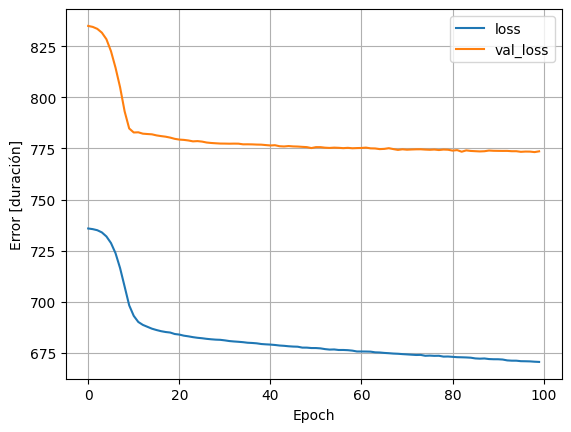

In [28]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
# plt.ylim([0,10])
plt.xlabel("Epoch")
plt.ylabel("Error [duración]")
plt.legend()
plt.grid(True)

In [31]:
print(etiquetas_prueba[:10])
features_prueba[:10]
# print(modelo.predict(features_prueba[:10]))

5        0.0
8        0.0
13       0.0
16     600.0
19     600.0
22     300.0
23       0.0
30     900.0
35       0.0
37    2100.0
Name: duracion, dtype: float64


,speed,severity,level,length,roadType,delay,tiempo_min,x1,y1,x2,y2
5,0.000000,2,5,150,1,-1,1.551755e+09,-99.135717,19.422549,-99.134948,19.423583
8,3.058333,5,3,440,7,89,1.572337e+09,-99.224125,19.322729,-99.221082,19.320826
13,2.144444,5,3,286,7,80,1.572337e+09,-99.250966,19.329340,-99.248533,19.330482
16,2.336111,0,2,660,1,161,1.548069e+09,-99.186415,19.353366,-99.184577,19.359071
19,2.436111,0,2,315,1,71,1.557072e+09,-99.142153,19.488160,-99.139198,19.487588
22,1.266667,5,3,323,2,193,1.562294e+09,-99.131669,19.478713,-99.133564,19.476418
23,4.536111,5,3,551,6,74,1.570742e+09,-99.156000,19.463588,-99.150803,19.462782
30,2.427778,5,2,360,1,89,1.570742e+09,-99.232541,19.299859,-99.231919,19.296747
35,1.647222,5,3,303,1,76,1.558820e+09,-99.055416,19.295262,-99.055504,19.298001
37,2.413889,0,2,645,1,131,1.550008e+09,-99.154722,19.382232,-99.153767,19.387977
